<a href="https://colab.research.google.com/github/Al-Tayeb96/Cirrhosis-Prediction-Project-4---Part-1-Core-/blob/main/Project_4_Part_2_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer,make_column_selector

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')



In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



In [2]:
# Load Data
df = pd.read_csv('/content/drive/MyDrive/ CodingDojo/Intermediate ML/cirrhosis.csv',index_col='ID')
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [3]:
# Define target
target_col = "Status"


# Define X and y
y = df[target_col].replace({'D':0,'C':1,'CL':2}).copy()
X = df.drop(columns=[target_col]).copy()

# Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=321)

In [4]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline( impute_na,ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical',ohe_pipe, ohe_cols)
#________________________________________________________________________
# Numerical Prepprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
impute_na = SimpleImputer(strategy='constant', fill_value = 0)
# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline( impute_na,scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
#_________________________________________________________________


In [5]:
# Create the Column Transformer
prepprocessing=ColumnTransformer([num_tuple,ohe_tuple],verbose_feature_names_out=True)
prepprocessing

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))])

In [6]:
prepprocessing.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))])

In [7]:
# Transform the training data
X_train_processed = prepprocessing.transform(X_train)
# Transform the testing data
X_test_processed = prepprocessing.transform(X_test)
# View the processed training data
X_train_processed.head()



,numeric__N_Days,numeric__Age,numeric__Bilirubin,numeric__Cholesterol,numeric__Albumin,numeric__Copper,numeric__Alk_Phos,numeric__SGOT,numeric__Tryglicerides,numeric__Platelets,numeric__Prothrombin,numeric__Stage,categorical__Drug_D-penicillamine,categorical__Drug_NA,categorical__Drug_Placebo,categorical__Sex_F,categorical__Sex_M,categorical__Ascites_N,categorical__Ascites_NA,categorical__Ascites_Y,categorical__Hepatomegaly_N,categorical__Hepatomegaly_NA,categorical__Hepatomegaly_Y,categorical__Spiders_N,categorical__Spiders_NA,categorical__Spiders_Y,categorical__Edema_N,categorical__Edema_S,categorical__Edema_Y
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
264,-0.302035,-0.685826,0.024908,0.349661,-0.864815,1.244767,0.164428,-0.052198,0.538956,0.699685,0.377487,-0.020418,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
273,-0.286935,-0.367328,-0.243156,0.245800,-0.038809,-0.030245,0.055278,-0.121075,0.363859,-0.441972,-0.790903,-0.020418,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
301,-0.535145,-0.581875,-0.511220,0.486907,0.228428,-0.312327,-0.117310,-0.300157,0.201269,0.473322,-0.133684,1.044725,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
86,-0.193502,0.151096,0.382327,4.964079,-0.646166,-0.030245,0.511935,-0.187887,1.089260,-0.648652,0.158414,-0.020418,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
286,-0.428499,-1.199198,-0.287833,0.179032,-0.281752,-0.086661,-0.140632,0.361068,0.388873,-1.022643,-0.644854,-0.020418,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [8]:
from imblearn.over_sampling import SMOTE,SMOTENC
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_processed , y_train)
y_train_sm.value_counts()

2    173
1    173
0    173
Name: Status, dtype: int64

In [12]:
defult_model=RandomForestClassifier(random_state = 321)
defult_model.fit(X_train_sm, y_train_sm)

RandomForestClassifier(random_state=321)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       173
           1       1.00      1.00      1.00       173
           2       1.00      1.00      1.00       173

    accuracy                           1.00       519
   macro avg       1.00      1.00      1.00       519
weighted avg       1.00      1.00      1.00       519



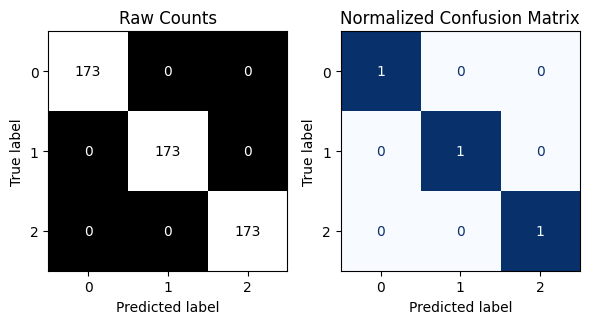


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.58      0.64        38
           1       0.75      0.88      0.81        59
           2       0.20      0.12      0.15         8

    accuracy                           0.71       105
   macro avg       0.55      0.53      0.53       105
weighted avg       0.70      0.71      0.70       105



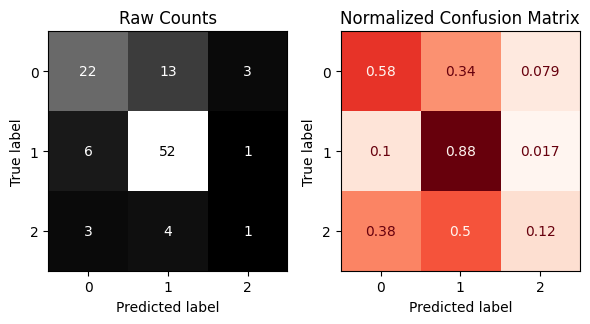

In [14]:
#use costum function to evaluate model befor pridctution
evaluate_classification(defult_model, X_train_sm, y_train_sm, X_test_processed, y_test)

# Kmeans feature engineering

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

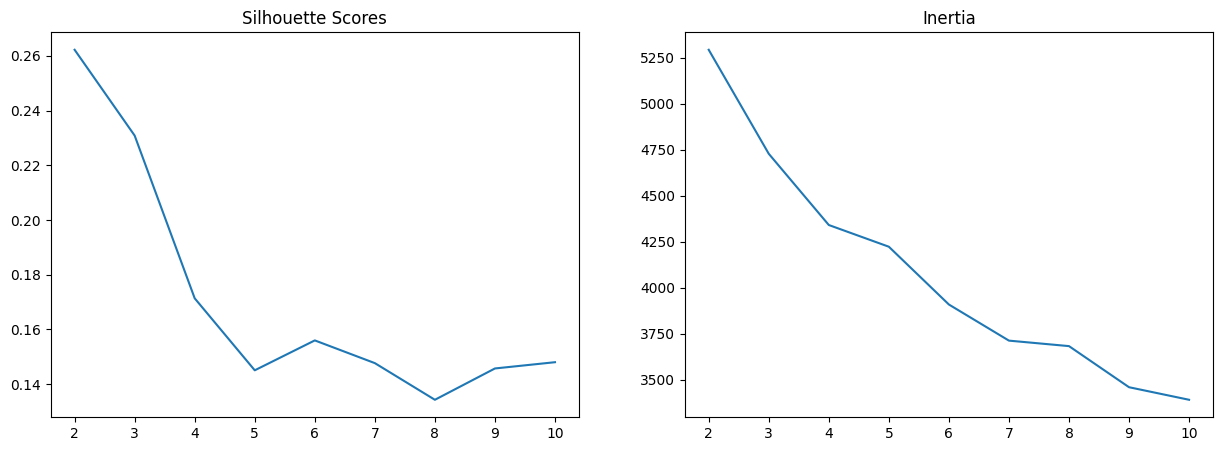

In [17]:
# Iterate over a range of k clusters to find the optimal number of clusters
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=42)
  kmeans.fit(X_train_sm)
  sils.append(silhouette_score(X_train_sm, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

In [25]:
# Refit KMeans with 4 clusters
kmeans = KMeans(n_clusters=2, n_init= 'auto', random_state=321)
kmeans.fit(X_train_sm)
# Add the clusters as a column in the dataframe
X_train_sm['cluster'] = kmeans.labels_
X_train_sm.head()

,numeric__N_Days,numeric__Age,numeric__Bilirubin,numeric__Cholesterol,numeric__Albumin,numeric__Copper,numeric__Alk_Phos,numeric__SGOT,numeric__Tryglicerides,numeric__Platelets,numeric__Prothrombin,numeric__Stage,categorical__Drug_D-penicillamine,categorical__Drug_NA,categorical__Drug_Placebo,categorical__Sex_F,categorical__Sex_M,categorical__Ascites_N,categorical__Ascites_NA,categorical__Ascites_Y,categorical__Hepatomegaly_N,categorical__Hepatomegaly_NA,categorical__Hepatomegaly_Y,categorical__Spiders_N,categorical__Spiders_NA,categorical__Spiders_Y,categorical__Edema_N,categorical__Edema_S,categorical__Edema_Y,cluster
0,-0.302035,-0.685826,0.024908,0.349661,-0.864815,1.244767,0.164428,-0.052198,0.538956,0.699685,0.377487,-0.020418,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1,-0.286935,-0.367328,-0.243156,0.245800,-0.038809,-0.030245,0.055278,-0.121075,0.363859,-0.441972,-0.790903,-0.020418,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
2,-0.535145,-0.581875,-0.511220,0.486907,0.228428,-0.312327,-0.117310,-0.300157,0.201269,0.473322,-0.133684,1.044725,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
3,-0.193502,0.151096,0.382327,4.964079,-0.646166,-0.030245,0.511935,-0.187887,1.089260,-0.648652,0.158414,-0.020418,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0
4,-0.428499,-1.199198,-0.287833,0.179032,-0.281752,-0.086661,-0.140632,0.361068,0.388873,-1.022643,-0.644854,-0.020418,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0


In [32]:
kmeans.fit_transform(X_test_processed)
X_test_processed['cluster'] = kmeans.labels_
X_test_processed.head()


,numeric__N_Days,numeric__Age,numeric__Bilirubin,numeric__Cholesterol,numeric__Albumin,numeric__Copper,numeric__Alk_Phos,numeric__SGOT,numeric__Tryglicerides,numeric__Platelets,numeric__Prothrombin,numeric__Stage,categorical__Drug_D-penicillamine,categorical__Drug_NA,categorical__Drug_Placebo,categorical__Sex_F,categorical__Sex_M,categorical__Ascites_N,categorical__Ascites_NA,categorical__Ascites_Y,categorical__Hepatomegaly_N,categorical__Hepatomegaly_NA,categorical__Hepatomegaly_Y,categorical__Spiders_N,categorical__Spiders_NA,categorical__Spiders_Y,categorical__Edema_N,categorical__Edema_S,categorical__Edema_Y,cluster
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
311,-0.965501,-1.282146,-0.287833,-0.054656,-0.767638,-0.097945,-0.237188,0.292190,0.013666,0.866996,-0.133684,-1.085562,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
357,0.661549,0.660214,-0.064447,-0.970863,-0.038809,-0.876492,-0.726964,-1.319547,-1.086943,-1.357266,-0.206708,1.044725,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
204,0.215148,1.104729,-0.578236,-0.024982,0.641431,-0.616976,-0.249316,-0.251943,-0.361542,0.335535,-0.352757,-0.020418,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
256,-0.151976,-1.918610,-0.488882,0.275475,0.641431,-0.334894,-0.343073,-0.162402,0.263804,-0.048297,-0.717879,-0.020418,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
350,-1.132548,-0.310966,-0.265495,-0.970863,1.516026,-0.876492,-0.726964,-1.319547,-1.086943,-0.461656,-1.229049,-0.020418,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0


In [31]:
Kmeans_model=RandomForestClassifier(random_state=321)
Kmeans_model.fit(X_train_sm,y_train_sm)

RandomForestClassifier(random_state=321)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       173
           1       1.00      1.00      1.00       173
           2       1.00      1.00      1.00       173

    accuracy                           1.00       519
   macro avg       1.00      1.00      1.00       519
weighted avg       1.00      1.00      1.00       519



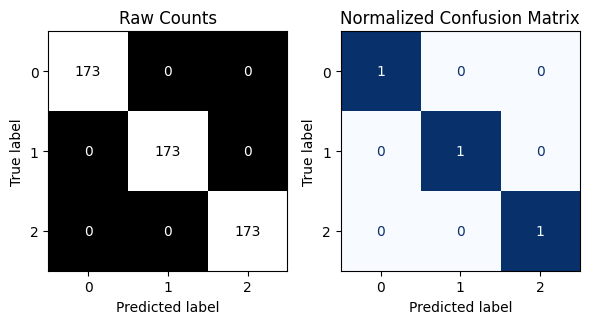


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        38
           1       0.80      0.93      0.86        59
           2       0.00      0.00      0.00         8

    accuracy                           0.74       105
   macro avg       0.51      0.51      0.51       105
weighted avg       0.71      0.74      0.72       105



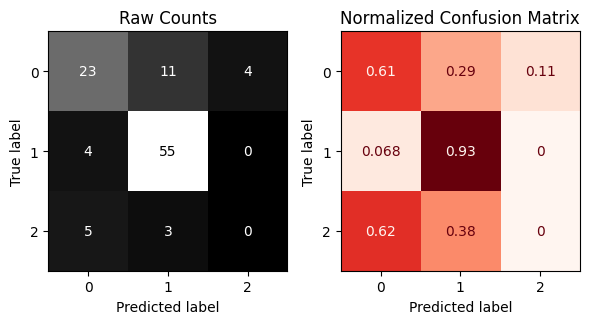

In [33]:
#use costum function to evaluate model befor pridctution
evaluate_classification(Kmeans_model, X_train_sm, y_train_sm, X_test_processed, y_test)

In [34]:
from sklearn.decomposition import PCA


In [37]:
# Instantiate & fit data using PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_sm)
X_test_pca = pca.transform(X_test_processed)
X_train_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29
0,1.146515,0.402878,0.455006,-0.302720,0.086672,-0.398043,0.629189,-0.043127,0.389357,1.207033,-0.641915,-0.134840,-0.527419,0.118652,0.269339,-0.118562,-0.038307,0.035351,-0.117000,-0.049044,0.022897,-8.810366e-16,5.532247e-16,2.014401e-16,1.794191e-16,-5.301421e-17,2.258496e-16,9.439802e-17,4.202354e-16,-7.023899e-17
1,-0.017208,-0.191472,0.216061,-0.331988,-0.397610,0.160486,-0.444481,0.400219,0.343650,0.232664,0.112600,0.335675,-0.221387,-0.099955,1.383855,-0.120463,0.515070,0.357542,-0.013543,-0.057737,0.006623,1.263891e-16,-8.499833e-17,-3.676776e-16,-1.242866e-16,5.987952e-16,5.665841e-16,1.907556e-16,-1.624968e-16,-2.468113e-17
2,0.112841,-0.395816,0.466910,-0.044216,-0.740615,-0.017825,-0.384313,-1.060906,-0.085367,-0.080716,0.001531,0.301220,0.613486,-0.760887,0.565801,-0.500692,0.369847,0.041143,0.129544,0.002235,-0.003134,-2.674050e-16,3.780196e-16,-3.179320e-16,4.703161e-17,9.112894e-17,-1.135383e-16,-1.743599e-16,-6.579257e-18,-1.708051e-16
3,2.416593,0.475105,-0.064010,0.444338,0.912556,3.184957,-1.147831,0.021702,0.568534,-0.564582,-2.729665,-0.038102,-0.035988,0.577702,0.574450,-0.355573,0.809133,-0.055342,0.201725,0.085314,0.008134,-3.576693e-16,-6.676868e-16,-1.094500e-16,-2.344313e-16,-1.033588e-15,-5.806943e-16,4.698233e-16,-4.363420e-16,9.302529e-18
4,0.220652,0.209155,0.217970,-0.997384,-0.921877,0.652239,-0.182542,0.968649,0.288316,-0.123822,-0.220223,0.541289,-0.142265,1.044605,0.066431,-0.043681,-0.187596,0.323874,-0.062849,0.006838,0.005952,3.682467e-17,-4.578412e-16,5.218754e-16,-2.859206e-16,4.101359e-16,1.090052e-16,2.253031e-16,-4.790126e-16,3.178066e-17


In [38]:
# Determine how much variance is explained by each PC
explained = pd.Series(pca.explained_variance_ratio_, name='Explained Variance Ratio')
explained

0     2.722778e-01
1     1.550460e-01
2     7.635068e-02
3     6.697303e-02
4     5.938888e-02
5     5.632575e-02
6     4.840655e-02
7     4.057354e-02
8     3.810498e-02
9     3.594430e-02
10    2.870089e-02
11    2.496598e-02
12    2.448053e-02
13    2.012707e-02
14    1.298538e-02
15    1.175450e-02
16    1.068151e-02
17    8.478438e-03
18    5.940355e-03
19    1.959688e-03
20    5.341922e-04
21    1.500852e-33
22    1.500852e-33
23    1.500852e-33
24    1.500852e-33
25    1.500852e-33
26    1.500852e-33
27    1.500852e-33
28    1.500852e-33
29    1.500852e-33
Name: Explained Variance Ratio, dtype: float64

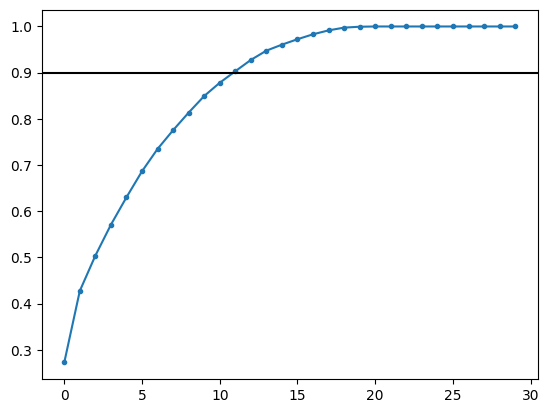

In [39]:
# plot the cumulative sum of the percentage of explained variance for each component and those before it.
ax = explained.cumsum().plot(marker='.')
# add a line to mark .9 (or 90%) variance explained
ax.axhline(.9, color='k');



In [41]:
# Define PCA to address 85% of the variance
pca10 = PCA(n_components=10)
# fit and transform on training data
X_train_pca10 = pca10.fit_transform(X_train_sm)
# transform test data
X_test_pca10 = pca10.transform(X_test_processed)
# obtain the number of PCs used
pca10.n_components_

10

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       173
           1       1.00      1.00      1.00       173
           2       1.00      1.00      1.00       173

    accuracy                           1.00       519
   macro avg       1.00      1.00      1.00       519
weighted avg       1.00      1.00      1.00       519



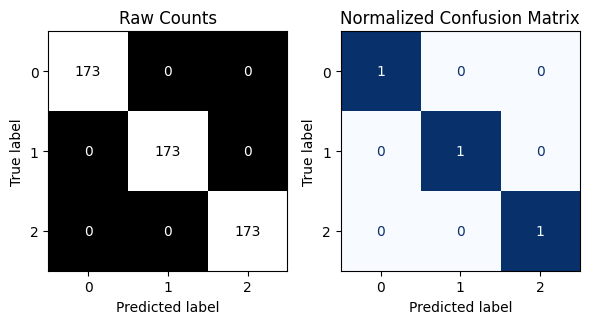


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.58      0.64        38
           1       0.74      0.86      0.80        59
           2       0.20      0.12      0.15         8

    accuracy                           0.70       105
   macro avg       0.55      0.52      0.53       105
weighted avg       0.69      0.70      0.69       105



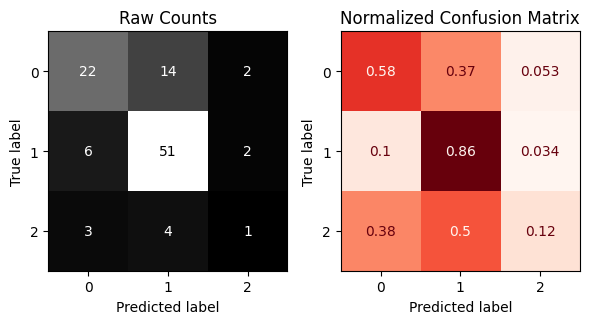

In [42]:
# Record the start time
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca10, y_train_sm)


evaluate_classification(clf, X_train_pca10,y_train_sm, X_test_pca10, y_test)


#Filter Method - Variance

In [43]:
from sklearn.feature_selection import VarianceThreshold


In [69]:
# checking for constant-features
selector = VarianceThreshold(threshold=0.09)
selector.fit(X_train_sm)

VarianceThreshold(threshold=0.09)

In [70]:
# get support returns true/false for keeping features
keep_features = selector.get_support()
keep_features[:20]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True, False])

In [71]:
# Number of features to keep (non-constant features)
keep_features.sum()

25

In [72]:
# Filter based on variance
X_train_var = X_train_sm.loc[:,keep_features]
X_test_var = X_test_processed.loc[:,keep_features]
X_train_var

,numeric__N_Days,numeric__Age,numeric__Bilirubin,numeric__Cholesterol,numeric__Albumin,numeric__Copper,numeric__Alk_Phos,numeric__SGOT,numeric__Tryglicerides,numeric__Platelets,numeric__Prothrombin,numeric__Stage,categorical__Drug_D-penicillamine,categorical__Drug_NA,categorical__Drug_Placebo,categorical__Ascites_N,categorical__Ascites_NA,categorical__Hepatomegaly_N,categorical__Hepatomegaly_NA,categorical__Hepatomegaly_Y,categorical__Spiders_N,categorical__Spiders_NA,categorical__Spiders_Y,categorical__Edema_N,cluster
0,-0.302035,-0.685826,0.024908,0.349661,-0.864815,1.244767,0.164428,-0.052198,0.538956,0.699685,0.377487,-0.020418,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.0,0.000000,1.000000,1.000000,0
1,-0.286935,-0.367328,-0.243156,0.245800,-0.038809,-0.030245,0.055278,-0.121075,0.363859,-0.441972,-0.790903,-0.020418,0.000000,0.000000,1.000000,1.000000,0.000000,1.00000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0
2,-0.535145,-0.581875,-0.511220,0.486907,0.228428,-0.312327,-0.117310,-0.300157,0.201269,0.473322,-0.133684,1.044725,0.000000,0.000000,1.000000,1.000000,0.000000,1.00000,0.000000,0.000000,1.0,0.000000,0.000000,1.000000,0
3,-0.193502,0.151096,0.382327,4.964079,-0.646166,-0.030245,0.511935,-0.187887,1.089260,-0.648652,0.158414,-0.020418,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.0,0.000000,1.000000,1.000000,0
4,-0.428499,-1.199198,-0.287833,0.179032,-0.281752,-0.086661,-0.140632,0.361068,0.388873,-1.022643,-0.644854,-0.020418,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.0,0.000000,1.000000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,0.406350,-0.909787,-0.582295,-0.128330,0.495656,-0.300525,-0.118986,-0.281037,0.703818,1.486551,-0.442379,-0.601368,0.000000,0.000000,1.000000,1.000000,0.000000,0.77271,0.000000,0.227290,1.0,0.000000,0.000000,1.000000,0
515,-0.565836,-1.557006,-0.498134,0.410331,0.037240,-0.438846,-0.161678,0.936440,-0.256871,-0.222963,0.463043,1.044725,0.000000,0.138065,0.861935,0.861935,0.138065,0.00000,0.138065,0.861935,0.0,0.138065,0.861935,0.000000,0
516,0.422157,-1.169391,-0.433707,0.044474,0.361698,-0.419573,-0.091002,-0.322775,0.627933,1.570171,-0.191174,-1.085562,0.292066,0.000000,0.707934,1.000000,0.000000,1.00000,0.000000,0.000000,1.0,0.000000,0.000000,1.000000,0
517,0.362273,-0.363440,-0.182134,0.197760,0.229020,0.026997,-0.223769,0.642837,0.834698,0.005952,-0.545113,0.706998,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.0,0.000000,0.000000,0.841464,0


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       173
           1       1.00      1.00      1.00       173
           2       1.00      1.00      1.00       173

    accuracy                           1.00       519
   macro avg       1.00      1.00      1.00       519
weighted avg       1.00      1.00      1.00       519



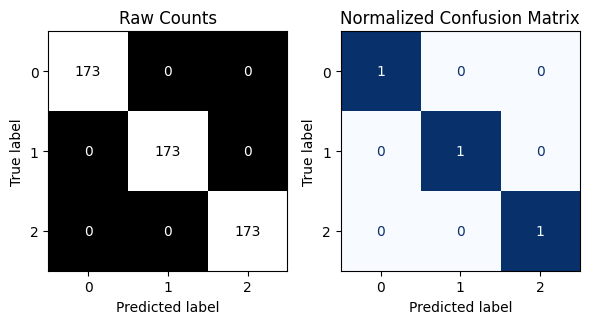


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        38
           1       0.78      0.88      0.83        59
           2       0.20      0.12      0.15         8

    accuracy                           0.72       105
   macro avg       0.56      0.54      0.54       105
weighted avg       0.70      0.72      0.71       105



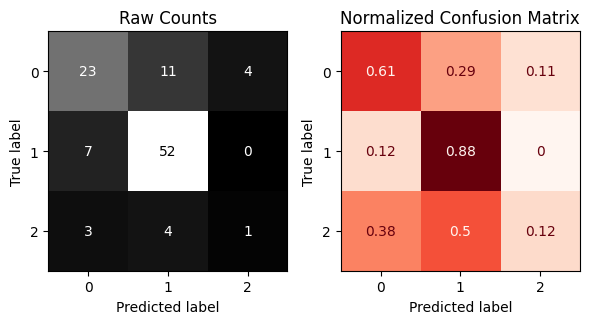

In [74]:
# Test the performance
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_var, y_train_sm)
evaluate_classification(rf_clf, X_train_var, y_train_sm, X_test_var, y_test)



In [77]:
from sklearn.inspection import permutation_importance

r = permutation_importance(rf_clf, X_train_var, y_train_sm ,n_repeats =5, random_state = 321)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [79]:
## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_var.columns,
                           name = 'permutation importance')
perm_importances.head()

numeric__N_Days         0.023507
numeric__Age            0.183044
numeric__Bilirubin      0.068979
numeric__Cholesterol    0.001541
numeric__Albumin        0.000771
Name: permutation importance, dtype: float64

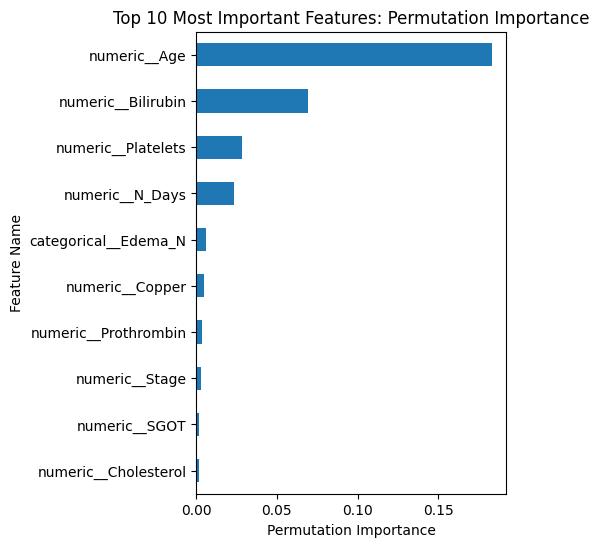

In [80]:
ax = perm_importances.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
       title='Top 10 Most Important Features: Permutation Importance');

after N_days the fetuers importanc changed

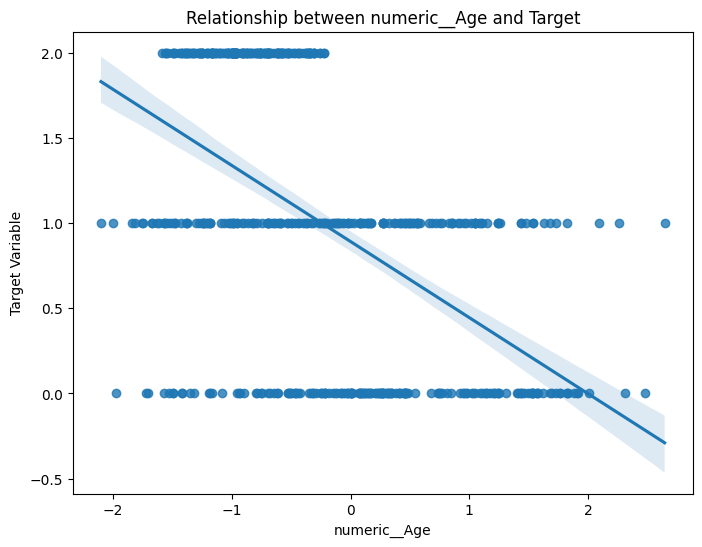

In [81]:
feature="numeric__Age"
# Scatter plot or other visualizations to show the relationship with the target
plt.figure(figsize=(8, 6))
sns.regplot(x=X_train_var[feature], y=y_train_sm)
plt.title(f"Relationship between {feature} and Target")
plt.xlabel(feature)
plt.ylabel("Target Variable")
plt.show()